In [188]:
import jax
import jax.numpy as jnp
from sklearn.linear_model import LogisticRegression
import os
import pickle
from variational.exponential_family import GenericMeanFieldNormalDistribution, NormalDistribution, MeanFieldNormalDistribution
from experiments.logisticRegression.mnist.load_mnist import mnist_dataset
import matplotlib.pyplot as plt

OUTPUT_PATH = "./output_mean_field/"
OP_key = jax.random.PRNGKey(0)
logreg = LogisticRegression(penalty=None, fit_intercept=False)
jax.config.update("jax_enable_x64", True)
mnist_train, mnist_test = mnist_dataset(return_test=True, flip=False)
flipped_predictors, response = mnist_train
flipped_predictors_test, response_test = mnist_test
N, dim = flipped_predictors.shape

In [189]:
PKLs = []
PKL_titles = []
for file in os.listdir(OUTPUT_PATH):
    if file.endswith(".pkl"):
        PKLs.append(pickle.load(open(OUTPUT_PATH + "/"+ file, "rb")))
        PKL_titles.append(str(file))

full_gaussian = GenericMeanFieldNormalDistribution(dimension=dim)

In [5]:
logreg.fit(flipped_predictors, response)
test_prediction = logreg.predict(flipped_predictors_test)
jnp.sum(test_prediction != response_test) / len(response_test)

Array(0.01074719, dtype=float64)

In [6]:
from sklearn.metrics import log_loss

log_loss(response_test, logreg.predict_proba(flipped_predictors_test))
log_loss(response, logreg.predict_proba(flipped_predictors))

0.0010100226273692804

In [193]:
"""
Computing the mean of the regression coefficients, for each repetitions, iterations
Computing the rates of missclasification
"""
my_etas = PKLs[0]['res'][..., :-1]
print(my_etas.shape)
d = my_etas.shape[-1]
shape = my_etas.shape
my_etas = my_etas.reshape((-1, d))
my_mean_betas = jax.vmap(full_gaussian.get_mean_cov)(my_etas)[0]

def missclassification_over_test(betas):
    u = (flipped_predictors_test@betas.T).T
    classification = jax.vmap(lambda x: (x<0)*(-1.) + (x>0)*1.)(u)
    rates = jnp.mean(classification != response_test, axis=-1)
    print(rates)
    rates = rates.reshape(shape[:-1])
    return rates

(501, 1568)


[1.         0.03428864 0.02507677 0.03991812 0.05629478 0.05322415
 0.03480041 0.03633572 0.01688843 0.01791197 0.01125896 0.01125896
 0.01023541 0.01023541 0.01023541 0.01023541 0.01023541 0.00972364
 0.00972364 0.00972364 0.00921187 0.00921187 0.00921187 0.00921187
 0.0087001  0.0087001  0.0087001  0.00818833 0.00818833 0.00818833
 0.00818833 0.00818833 0.00818833 0.00818833 0.00767656 0.00767656
 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656
 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656
 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656
 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656
 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656 0.00767656
 0.00716479 0.00716479 0.00716479 0.00716479 0.00716479 0.00716479
 0.00716479 0.00716479 0.00716479 0.00716479 0.00716479 0.00716479
 0.00716479 0.00716479 0.00716479 0.00716479 0.00716479 0.00716479
 0.00716479 0.00716479 0.00716479 0.00716479 0.00716479 0.0071

ValueError: 'x' and 'y' must have the same size

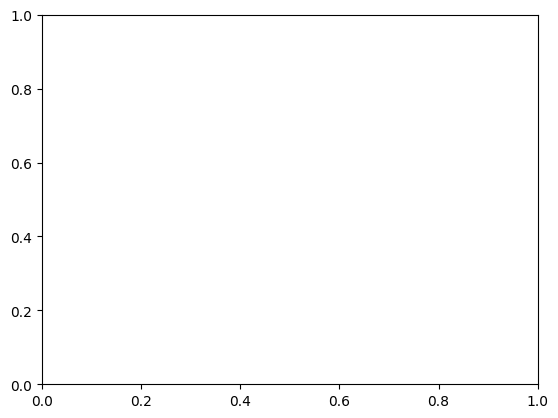

In [194]:
rates_for_lsvi = missclassification_over_test(my_mean_betas).T
#rates_blackjax = missclassification_over_test(PKLs[0]['states'][0].reshape((t, -1)))
start = 1
end = 5+1
plt.errorbar(x=range(start, end), y=rates_for_lsvi[start:end].mean(axis=-1), yerr=rates_for_lsvi[start:end].std(axis=-1), label="MF-LVSI", ecolor="red", color="black")
plt.xlabel("Iteration")
plt.ylabel("Misclassification rate")

In [195]:
rates_for_lsvi.shape

(501,)

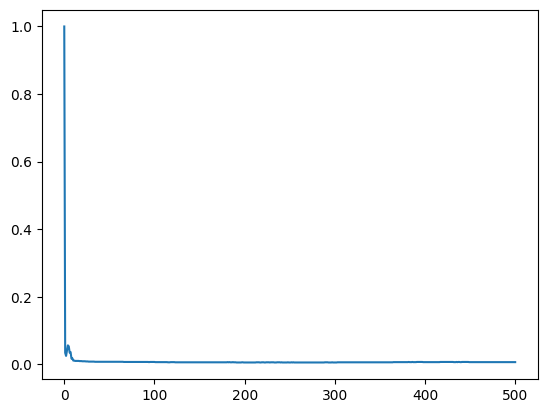

In [196]:
plt.plot(rates_for_lsvi)